In [39]:
from datetime import datetime, timedelta, date
import time
import datetime
import pandas as pd

fecha_actual = date.today()

# Calcular la fecha dentro de tres meses
fecha_final = fecha_actual + timedelta(days=180)

# Crear un rango de fechas diarias desde hoy hasta dentro de tres meses
rango_fechas = pd.date_range(start=fecha_actual, end=fecha_final, freq='D')

# Crear un dataframe con las fechas
df_fechas = pd.DataFrame(rango_fechas, columns=['fecha'])

# Mostrar el dataframe
print(df_fechas)

         fecha
0   2024-06-19
1   2024-06-20
2   2024-06-21
3   2024-06-22
4   2024-06-23
..         ...
176 2024-12-12
177 2024-12-13
178 2024-12-14
179 2024-12-15
180 2024-12-16

[181 rows x 1 columns]


In [40]:
from prophet import Prophet

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Cargar y preparar el dataset
df = pd.read_csv('abiertocerrado.csv')
df = df[['fecha', 'abierto/cerrado']].rename(columns={'fecha': 'ds', 'abierto/cerrado': 'y'})

# Convertir la columna de fechas a formato datetime
df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')

# Dividir los datos en entrenamiento y prueba
train_size = 0.7  # 70% para entrenamiento
train, test = train_test_split(df, train_size=train_size, shuffle=False, random_state=42)

# Inicializar el modelo Prophet desactivando la tendencia y la estacionalidad
model = Prophet(growth='flat', daily_seasonality=False, seasonality_prior_scale=0.1, changepoint_prior_scale=0.5)
# Entrenar el modelo
model.fit(train)

# Realizar predicciones en el conjunto de prueba
future = test[['ds']].copy()  # Utilizar las fechas del conjunto de prueba para las predicciones
forecast = model.predict(future)

# Convertir las predicciones en valores binarios
threshold = 0.5  # Umbral para la clasificación
forecast['yhat_binary'] = (forecast['yhat'] > threshold).astype(int)

forecast[['ds', 'yhat']].to_csv('forecast.csv', index=False)

# Evaluar el modelo
accuracy = accuracy_score(test['y'], forecast['yhat_binary'])
conf_matrix = confusion_matrix(test['y'], forecast['yhat_binary'])
class_report = classification_report(test['y'], forecast['yhat_binary'])

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)



13:04:45 - cmdstanpy - INFO - Chain [1] start processing
13:04:45 - cmdstanpy - INFO - Chain [1] done processing


Accuracy: 0.69
Confusion Matrix:
[[395 338]
 [139 680]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.54      0.62       733
           1       0.67      0.83      0.74       819

    accuracy                           0.69      1552
   macro avg       0.70      0.68      0.68      1552
weighted avg       0.70      0.69      0.69      1552



In [41]:
df_fechas = df_fechas[['fecha']].rename(columns={'fecha': 'ds'})
forecast = model.predict(df_fechas)
forecast[['ds', 'yhat']].to_csv('forecast.csv', index=False)

12:14:18 - cmdstanpy - INFO - Chain [1] start processing
12:14:18 - cmdstanpy - INFO - Chain [1] done processing
12:14:18 - cmdstanpy - INFO - Chain [1] start processing
12:14:18 - cmdstanpy - INFO - Chain [1] done processing
12:14:19 - cmdstanpy - INFO - Chain [1] start processing
12:14:19 - cmdstanpy - INFO - Chain [1] done processing
12:14:19 - cmdstanpy - INFO - Chain [1] start processing
12:14:19 - cmdstanpy - INFO - Chain [1] done processing


Average Accuracy: 0.75
Average Confusion Matrix:
[[276.25 156.25]
 [106.75 494.75]]
Average Classification Report:
{'0': {'precision': 0.7259662965553418, 'recall': 0.6616173675718678, 'f1-score': 0.6761115439459836}, '1': {'precision': 0.766358656742688, 'recall': 0.8350948131071176, 'f1-score': 0.7873633981523861}}


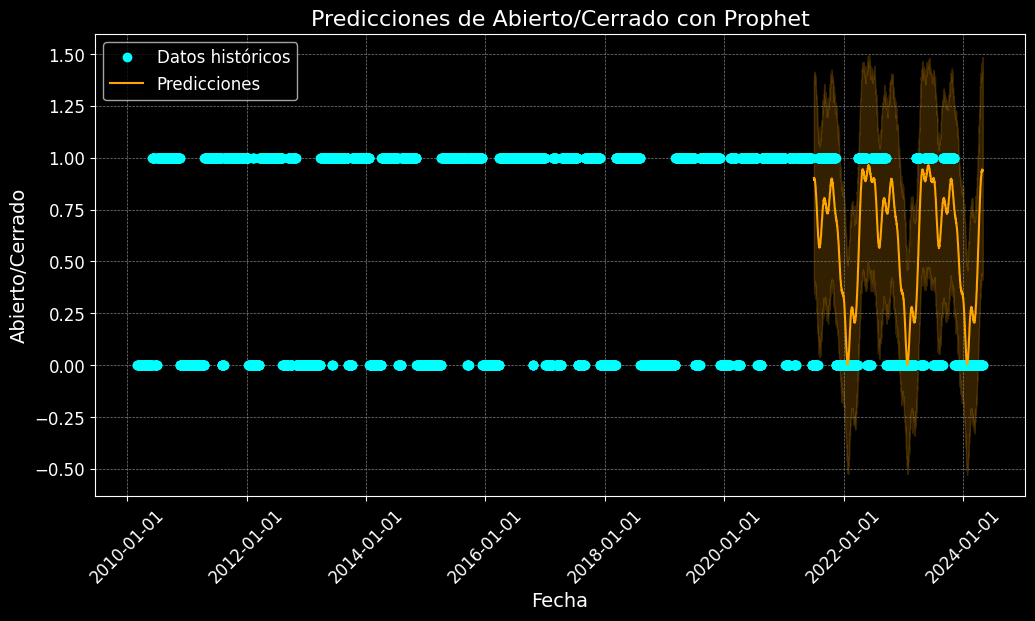

In [4]:
#Claro, una forma más robusta de dividir los datos en conjuntos de entrenamiento y prueba es utilizar la validación cruzada. En particular, puedes usar la validación cruzada de tipo "time series split" (división por series temporales) para evitar la fuga de datos y respetar la naturaleza secuencial de los datos temporales.
#En la validación cruzada para series temporales, los datos se dividen en varios pliegues (folds), y cada pliegue se utiliza a su vez como conjunto de prueba mientras que los anteriores se utilizan como conjunto de entrenamiento. Esto es más adecuado para datos de series temporales porque mantiene el orden temporal de los datos y evita que se utilicen datos futuros para predecir datos pasados.
from prophet import Prophet
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter


# Cargar y preparar el dataset
df = pd.read_csv('abiertocerrado.csv')
df = df[['fecha', 'abierto/cerrado']].rename(columns={'fecha': 'ds', 'abierto/cerrado': 'y'})

# Convertir la columna de fechas a formato datetime
df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')



# Definir TimeSeriesSplit para la validación cruzada
tscv = TimeSeriesSplit(n_splits=4)

accuracies = []
conf_matrices = []
reports = []

for train_index, test_index in tscv.split(df):
    train_df, test_df = df.iloc[train_index], df.iloc[test_index]

    # Inicializar un nuevo modelo Prophet para cada pliegue
    model = Prophet(growth='flat')

    # Entrenar el modelo con los datos de entrenamiento
    model.fit(train_df)

    # Realizar predicciones en el conjunto de prueba
    future = test_df[['ds']].copy()  # Utilizar las fechas del conjunto de prueba para las predicciones
    forecast = model.predict(future)

    # Convertir las predicciones en valores binarios
    threshold = 0.5  # Umbral para la clasificación
    forecast['yhat_binary'] = (forecast['yhat'] > threshold).astype(int)

    # Evaluar el modelo
    accuracy = accuracy_score(test_df['y'], forecast['yhat_binary'])
    accuracies.append(accuracy)
    conf_matrix = confusion_matrix(test_df['y'], forecast['yhat_binary'])
    conf_matrices.append(conf_matrix)
    class_report = classification_report(test_df['y'], forecast['yhat_binary'], output_dict=True)
    reports.append(class_report)

# Calcular las métricas promedio
avg_accuracy = np.mean(accuracies)
avg_conf_matrix = np.mean(conf_matrices, axis=0)

# Calcular el promedio del reporte de clasificación
# Inicializar un diccionario vacío para almacenar las métricas promedio
avg_precision_0 = []
avg_precision_1 = []
avg_recall_0 = []
avg_recall_1 = []
avg_f1_score_0 = []
avg_f1_score_1 = []

# Calcular las medias de cada métrica
for report in reports:
    avg_precision_0.append(report['0']['precision'])
    avg_precision_1.append(report['1']['precision'])
    avg_recall_0.append(report['0']['recall'])
    avg_recall_1.append(report['1']['recall'])
    avg_f1_score_0.append(report['0']['f1-score'])
    avg_f1_score_1.append(report['1']['f1-score'])

avg_report = {
    '0': {
        'precision': np.mean(avg_precision_0),
        'recall': np.mean(avg_recall_0),
        'f1-score': np.mean(avg_f1_score_0)
    },
    '1': {
        'precision': np.mean(avg_precision_1),
        'recall': np.mean(avg_recall_1),
        'f1-score': np.mean(avg_f1_score_1)
    }
}

print(f"Average Accuracy: {avg_accuracy:.2f}")
print("Average Confusion Matrix:")
print(avg_conf_matrix)
print("Average Classification Report:")
print(avg_report)

# Personalizar la gráfica con fondo oscuro y colores llamativos
plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['ds'], df['y'], 'o', label='Datos históricos', color='cyan')
ax.plot(forecast['ds'], forecast['yhat'], '-', label='Predicciones', color='orange')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2)
ax.set_xlabel('Fecha', fontsize=14)
ax.set_ylabel('Abierto/Cerrado', fontsize=14)
ax.legend(loc='upper left', fontsize=12)
ax.set_title('Predicciones de Abierto/Cerrado con Prophet', fontsize=16)

# Personalización adicional del gráfico
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)

plt.show()

12:15:23 - cmdstanpy - INFO - Chain [1] start processing
12:15:23 - cmdstanpy - INFO - Chain [1] done processing
12:15:24 - cmdstanpy - INFO - Chain [1] start processing
12:15:24 - cmdstanpy - INFO - Chain [1] done processing


Average Accuracy: 0.74
Average Confusion Matrix:
[[437.  317. ]
 [126.5 843.5]]
Average Classification Report:
{'0': {'precision': 0.7764650283553876, 'recall': 0.5797165828472512, 'f1-score': 0.6637833222413251}, '1': {'precision': 0.7261643764352654, 'recall': 0.8688030436055019, 'f1-score': 0.7910976578007145}}


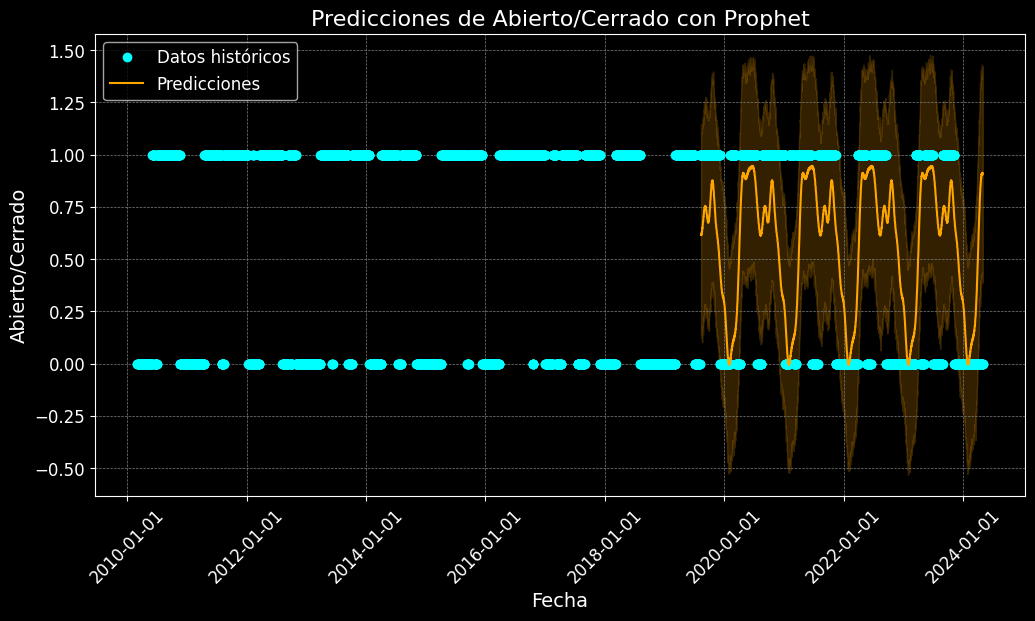

In [6]:
#Claro, una forma más robusta de dividir los datos en conjuntos de entrenamiento y prueba es utilizar la validación cruzada. En particular, puedes usar la validación cruzada de tipo "time series split" (división por series temporales) para evitar la fuga de datos y respetar la naturaleza secuencial de los datos temporales.
#En la validación cruzada para series temporales, los datos se dividen en varios pliegues (folds), y cada pliegue se utiliza a su vez como conjunto de prueba mientras que los anteriores se utilizan como conjunto de entrenamiento. Esto es más adecuado para datos de series temporales porque mantiene el orden temporal de los datos y evita que se utilicen datos futuros para predecir datos pasados.
from prophet import Prophet
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter


# Cargar y preparar el dataset
df = pd.read_csv('abiertocerrado.csv')
df = df[['fecha', 'abierto/cerrado']].rename(columns={'fecha': 'ds', 'abierto/cerrado': 'y'})

# Convertir la columna de fechas a formato datetime
df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')



# Definir TimeSeriesSplit para la validación cruzada
tscv = TimeSeriesSplit(n_splits=2)

accuracies = []
conf_matrices = []
reports = []

for train_index, test_index in tscv.split(df):
    train_df, test_df = df.iloc[train_index], df.iloc[test_index]

    # Inicializar un nuevo modelo Prophet para cada pliegue
    model = Prophet(growth='flat')

    # Entrenar el modelo con los datos de entrenamiento
    model.fit(train_df)

    # Realizar predicciones en el conjunto de prueba
    future = test_df[['ds']].copy()  # Utilizar las fechas del conjunto de prueba para las predicciones
    forecast = model.predict(future)

    # Convertir las predicciones en valores binarios
    threshold = 0.5  # Umbral para la clasificación
    forecast['yhat_binary'] = (forecast['yhat'] > threshold).astype(int)

    # Evaluar el modelo
    accuracy = accuracy_score(test_df['y'], forecast['yhat_binary'])
    accuracies.append(accuracy)
    conf_matrix = confusion_matrix(test_df['y'], forecast['yhat_binary'])
    conf_matrices.append(conf_matrix)
    class_report = classification_report(test_df['y'], forecast['yhat_binary'], output_dict=True)
    reports.append(class_report)

# Calcular las métricas promedio
avg_accuracy = np.mean(accuracies)
avg_conf_matrix = np.mean(conf_matrices, axis=0)

# Calcular el promedio del reporte de clasificación
# Inicializar un diccionario vacío para almacenar las métricas promedio
avg_precision_0 = []
avg_precision_1 = []
avg_recall_0 = []
avg_recall_1 = []
avg_f1_score_0 = []
avg_f1_score_1 = []

# Calcular las medias de cada métrica
for report in reports:
    avg_precision_0.append(report['0']['precision'])
    avg_precision_1.append(report['1']['precision'])
    avg_recall_0.append(report['0']['recall'])
    avg_recall_1.append(report['1']['recall'])
    avg_f1_score_0.append(report['0']['f1-score'])
    avg_f1_score_1.append(report['1']['f1-score'])

avg_report = {
    '0': {
        'precision': np.mean(avg_precision_0),
        'recall': np.mean(avg_recall_0),
        'f1-score': np.mean(avg_f1_score_0)
    },
    '1': {
        'precision': np.mean(avg_precision_1),
        'recall': np.mean(avg_recall_1),
        'f1-score': np.mean(avg_f1_score_1)
    }
}

print(f"Average Accuracy: {avg_accuracy:.2f}")
print("Average Confusion Matrix:")
print(avg_conf_matrix)
print("Average Classification Report:")
print(avg_report)

# Personalizar la gráfica con fondo oscuro y colores llamativos
plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['ds'], df['y'], 'o', label='Datos históricos', color='cyan')
ax.plot(forecast['ds'], forecast['yhat'], '-', label='Predicciones', color='orange')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2)
ax.set_xlabel('Fecha', fontsize=14)
ax.set_ylabel('Abierto/Cerrado', fontsize=14)
ax.legend(loc='upper left', fontsize=12)
ax.set_title('Predicciones de Abierto/Cerrado con Prophet', fontsize=16)

# Personalización adicional del gráfico
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)

plt.show()

In [21]:
# Python
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation, performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

12:31:56 - cmdstanpy - INFO - Chain [1] start processing
12:31:57 - cmdstanpy - INFO - Chain [1] done processing
12:32:38 - cmdstanpy - INFO - Chain [1] start processing
12:32:39 - cmdstanpy - INFO - Chain [1] done processing
12:33:20 - cmdstanpy - INFO - Chain [1] start processing
12:33:21 - cmdstanpy - INFO - Chain [1] done processing
12:34:01 - cmdstanpy - INFO - Chain [1] start processing
12:34:02 - cmdstanpy - INFO - Chain [1] done processing
12:34:42 - cmdstanpy - INFO - Chain [1] start processing
12:34:42 - cmdstanpy - INFO - Chain [1] done processing
12:35:10 - cmdstanpy - INFO - Chain [1] start processing
12:35:10 - cmdstanpy - INFO - Chain [1] done processing
12:35:39 - cmdstanpy - INFO - Chain [1] start processing
12:35:39 - cmdstanpy - INFO - Chain [1] done processing
12:36:07 - cmdstanpy - INFO - Chain [1] start processing
12:36:07 - cmdstanpy - INFO - Chain [1] done processing
12:36:36 - cmdstanpy - INFO - Chain [1] start processing
12:36:36 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  0.483568
1                     0.001                     0.10  0.477433
2                     0.001                     1.00  0.481027
3                     0.001                    10.00  0.479570
4                     0.010                     0.01  0.455083
5                     0.010                     0.10  0.457130
6                     0.010                     1.00  0.459880
7                     0.010                    10.00  0.459273
8                     0.100                     0.01  0.476298
9                     0.100                     0.10  0.468829
10                    0.100                     1.00  0.471373
11                    0.100                    10.00  0.470697
12                    0.500                     0.01  0.482393
13                    0.500                     0.10  0.452594
14                    0.500                     1.00  0

In [22]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1}
